In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!nvidia-smi

Sat May  4 20:35:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              44W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 476, done.
remote: Counting objects: 100% (207/207), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 476 (delta 141), reused 124 (delta 91), pack-reused 269
Receiving objects: 100% (476/476), 131.59 KiB | 14.62 MiB/s, done.
Resolving deltas: 100% (243/243), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.0 MB/s eta 0:00:00
***********************************************************************
Woo! Your instance has a NVIDIA A100-SXM4-40GB GPU!
We will install the latest stable RAPIDS via pip 24.4.*!  Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 473.3/473.3 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [ ]:
from cuml.svm import SVC
import cudf

import pandas as pd
import nltk
import re
import random
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, accuracy_score, precision_score, roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import GridSearchCV
from itertools import cycle
from nltk.corpus import stopwords


import pickle
import warnings

warnings.filterwarnings("ignore")

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
random_state = 42
testing_frac = 1
random.seed(random_state)
work_path = "/content/drive/MyDrive/Syncable/projects/data270"
data_path = f"{work_path}/data/combined.csv"

In [ ]:
df = pd.read_csv(data_path, low_memory=False)
df = df.drop_duplicates()
df = df[["overall", "reviewText", "summary"]]
df.dropna(inplace=True)
df["sentiment"] = df["overall"].apply(lambda x: 1 if x > 3 else -1 if x < 3 else 0)
df["reviewTextWithSummary"] = df["summary"] + " " + df["reviewText"]
df.drop(["overall", "summary", "reviewText"], axis=1, inplace=True)
df.head()

,sentiment,reviewTextWithSummary
0,1,Five Stars As advertised. Reasonably priced
1,1,Good for the face Like the oder and the feel w...
2,-1,Smells awful I bought this to smell nice after...
3,1,Truth is There IS Nothing Like an AQUA VELVA M...
4,1,Bvlgari Shampoo If you ever want to feel pampe...


# Model experimentation

In [ ]:
df_testing = df.sample(frac=testing_frac)
df_testing["sentiment"].value_counts()

sentiment
 1    606258
 0     43210
-1     41158
Name: count, dtype: int64

In [ ]:
df_testing.head()

,sentiment,reviewTextWithSummary
264778,0,but it's so easy for all the piece to mix and ...
675435,0,Farther away the worse it gets per section num...
476025,1,I have never tried the titanium needles before...
494345,1,Five Stars love these. great quality.
13507,1,... enough and when you can't sense quality of...


In [ ]:
print("Dataset size:", len(df_testing))

Dataset size: 690626


In [ ]:
STOP_WORDS = set(stopwords.words("english"))

In [ ]:
def preprocess_text(sentence, stop, type_proc=None):
    words = []
    for word in sentence.lower().strip().split():

        word = re.sub("\d", "", word)
        word = re.sub("[^\w\s]", "", word)

        if word not in stop and word != "":
            words.append(preprocess_type(word, type_proc))

    return " ".join(words)

In [ ]:
def preprocess_type(word, type_proc):
    if type_proc == "Baseline":
        return word
    elif type_proc == "Stemmed":
        return PorterStemmer().stem(word)
    elif type_proc == "Lemmatized":
        return WordNetLemmatizer().lemmatize(word)
    else:
        raise ValueError("Invalid Preprocessing Type")

In [ ]:
def train_val_test_split(df=df, random_state=random_state):
    x = df[["reviewTextWithSummary"]]
    y = df["sentiment"]
    x_train, x_tmp, y_train, y_tmp = train_test_split(
        x, y, test_size=0.3, random_state=random_state
    )
    x_val, x_test, y_val, y_test = train_test_split(
        x_tmp, y_tmp, test_size=0.5, random_state=random_state
    )
    return x_train, x_val, x_test, y_train, y_val, y_test

In [ ]:
def pipeline(proc, df, vectorizer=None, random_state=random_state):
    df_ = df.copy()
    if proc is not None:
        df_["reviewTextWithSummary"] = df_["reviewTextWithSummary"].apply(
            lambda x: preprocess_text(x, STOP_WORDS, proc)
        )

    x_train, x_val, x_test, y_train, y_val, y_test = train_val_test_split(
        df_, random_state
    )
    if vectorizer is None:
        vectorizer = TfidfVectorizer()
        vectorizer.fit(df_["reviewTextWithSummary"])
    x_train = vectorizer.transform(x_train["reviewTextWithSummary"])
    x_val = vectorizer.transform(x_val["reviewTextWithSummary"])
    x_test = vectorizer.transform(x_test["reviewTextWithSummary"])

    return x_train, x_val, x_test, y_train, y_val, y_test, vectorizer

In [ ]:
model_found = False
model = None
vectorizer = None
try:
    model = pickle.load(open(f"{work_path}/models/model_svm_clf.pkl", "rb"))
    vectorizer = pickle.load(open(f"{work_path}/models/model_svm_vectorizer.pkl", "rb"))
    model_found = True
    print("Model and vectorizer found")
except FileNotFoundError:
    print("Model and vectorizer not found")

Model and vectorizer not found


In [ ]:
if model_found:
    x_train, x_val, x_test, y_train, y_val, y_test, vectorizer = pipeline(None, df_testing, vectorizer)
    y_test_pred = model.predict(x_test)
    y_test_pred_proba = model.predict_proba(x_test)
    print(classification_report(y_test, y_test_pred))
    print()
    print("f1_score:", f1_score(y_test, y_test_pred, average="weighted"))
    print("accuracy:", accuracy_score(y_test, y_test_pred))
    print("precision:", precision_score(y_test, y_test_pred, average="weighted"))
    print("roc_auc:", roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr"))

    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)
    y_onehot_test.shape  # (n_samples, n_classes)

    class_of_interest = 1
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

    fpr, tpr, roc_auc = dict(), dict(), dict()
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_test_pred_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_test_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr_grid = np.linspace(0.0, 1.0, 1000)

    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(fpr_grid)

    for i in range(3):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

    # Average it and compute AUC
    mean_tpr /= 3

    fpr["macro"] = fpr_grid
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

    fig, ax = plt.subplots(figsize=(6, 6))

    target_names = ['negative', 'neutral', 'positive']

    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
        color="deeppink",
        linestyle=":",
        linewidth=2,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
        color="navy",
        linestyle=":",
        linewidth=2,
    )

    colors = cycle(["red", "blue", "orange"])
    for class_id, color in zip(range(3), colors):
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_test_pred_proba[:, class_id],
            name=f"ROC curve for {target_names[class_id]}",
            color=color,
            ax=ax,
        )

    _ = ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title="Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass",
    )



In [ ]:
if model_found:
    print("Stopping the execution of the notebook to avoid retraining the model and overwriting the existing notebook results")
    raise SystemExit("Stopping the execution of the notebook to avoid retraining the model and overwriting the existing notebook results")

## Testing different configs

In [ ]:
param_grid = {
    "C": [10, 1, 0.1, 0.01],
    "gamma": ["scale", 0.1, 0.01],
    "kernel": ["rbf", "linear"],
}
n_jobs = None
verbose = 3
cv = 3

In [ ]:
compare_list = pd.DataFrame(
    columns=[
        "tuning",
        "dataset",
        "proc",
        "C",
        "gamma",
        "kernel",
        "grid_score",
        "f1_score",
        "accuracy",
        "precision",
        "roc_auc",
    ]
)

### No preprocessing

In [ ]:
x_train, x_val, x_test, y_train, y_val, y_test, vec_noproc = pipeline(None, df_testing)

In [ ]:
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))

print(np.shape(y_train))
print(np.shape(y_val))
print(np.shape(y_test))

(483438, 118754)
(103594, 118754)
(103594, 118754)
(483438,)
(103594,)
(103594,)


In [ ]:
svc_noproc_prelim = SVC(verbose=True)
svc_noproc_prelim.fit(x_train, y_train)

[D] [20:45:07.895817] /__w/cuml/cuml/cpp/src/svm/workingset.cuh:118 Creating working set with 1024 elements
[D] [20:45:13.227635] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:255 SMO solver finished after 183 outer iterations, total inner 76365 iterations, and diff 0.000998
[D] [20:45:13.640032] /__w/cuml/cuml/cpp/src/svm/workingset.cuh:118 Creating working set with 1024 elements
[D] [20:45:44.738904] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:255 SMO solver finished after 314 outer iterations, total inner 131717 iterations, and diff 0.000996
[D] [20:45:44.865708] /__w/cuml/cuml/cpp/src/svm/workingset.cuh:118 Creating working set with 1024 elements
[D] [20:46:32.667244] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:255 SMO solver finished after 488 outer iterations, total inner 202578 iterations, and diff 0.000996


SVC()

In [ ]:
y_val_pred = svc_noproc_prelim.predict(x_val)
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

          -1       0.81      0.70      0.75      6193
           0       0.79      0.38      0.51      6493
           1       0.95      0.99      0.97     90908

    accuracy                           0.94    103594
   macro avg       0.85      0.69      0.74    103594
weighted avg       0.93      0.94      0.93    103594



In [ ]:
compare_list.loc[len(compare_list)] = [
    "before",
    "validation",
    None,
    "default",
    "default",
    "default",
    None,
    f1_score(y_val, y_val_pred, average="weighted"),
    accuracy_score(y_val, y_val_pred),
    precision_score(y_val, y_val_pred, average="weighted"),
    None,
]

In [ ]:
svc_noproc_grid = GridSearchCV(SVC(), param_grid, cv=cv, verbose=verbose, n_jobs=n_jobs)
svc_noproc_grid.fit(x_val, y_val)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END .....C=10, gamma=scale, kernel=rbf;, score=0.927 total time=  58.1s
[CV 2/3] END .....C=10, gamma=scale, kernel=rbf;, score=0.928 total time=   9.3s
[CV 3/3] END .....C=10, gamma=scale, kernel=rbf;, score=0.926 total time=   9.1s
[W] [20:48:06.537947] SVC with the linear kernel can be much faster using the specialized solver provided by LinearSVC. Consider switching to LinearSVC if tranining takes too long.
[CV 1/3] END ..C=10, gamma=scale, kernel=linear;, score=0.915 total time=  20.3s
[CV 2/3] END ..C=10, gamma=scale, kernel=linear;, score=0.917 total time=  20.3s
[CV 3/3] END ..C=10, gamma=scale, kernel=linear;, score=0.913 total time=  20.0s
[CV 1/3] END .......C=10, gamma=0.1, kernel=rbf;, score=0.927 total time=   6.2s
[CV 2/3] END .......C=10, gamma=0.1, kernel=rbf;, score=0.927 total time=   6.2s
[CV 3/3] END .......C=10, gamma=0.1, kernel=rbf;, score=0.925 total time=   6.1s
[CV 1/3] END ....C=10, gamma=

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [10, 1, 0.1, 0.01], 'gamma': ['scale', 0.1, 0.01],
                         'kernel': ['rbf', 'linear']},
             verbose=3)

In [ ]:
print(classification_report(y_val, svc_noproc_grid.predict(x_val)))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      6193
           0       1.00      1.00      1.00      6493
           1       1.00      1.00      1.00     90908

    accuracy                           1.00    103594
   macro avg       1.00      1.00      1.00    103594
weighted avg       1.00      1.00      1.00    103594



In [ ]:
print("best params for noproc")
print(svc_noproc_grid.best_params_)

best params for noproc
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [ ]:
svc_noproc = SVC(**svc_noproc_grid.best_params_, probability=True, verbose=True)
svc_noproc.fit(x_train, y_train)

[D] [20:54:59.308483] /__w/cuml/cuml/cpp/src/svm/workingset.cuh:118 Creating working set with 1024 elements
[D] [20:55:07.367594] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:255 SMO solver finished after 304 outer iterations, total inner 133049 iterations, and diff 0.001000
[D] [20:55:07.464550] /__w/cuml/cuml/cpp/src/svm/workingset.cuh:118 Creating working set with 1024 elements
[D] [20:55:48.239533] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:255 SMO solver finished after 491 outer iterations, total inner 212230 iterations, and diff 0.000996
[D] [20:55:48.340691] /__w/cuml/cuml/cpp/src/svm/workingset.cuh:118 Creating working set with 1024 elements
[D] [20:56:30.746015] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:252 SMO iteration 500, diff 0.045281
[D] [20:56:57.203802] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:255 SMO solver finished after 855 outer iterations, total inner 360176 iterations, and diff 0.000996
[D] [20:57:13.451425] /__w/cuml/cuml/cpp/src/svm/workingset.cuh:118 Creating working

SVC()

In [ ]:
y_test_pred = svc_noproc.predict(x_test)
y_test_pred_proba = svc_noproc.predict_proba(x_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

          -1       0.80      0.71      0.75      6209
           0       0.75      0.43      0.54      6360
           1       0.95      0.99      0.97     91025

    accuracy                           0.94    103594
   macro avg       0.83      0.71      0.76    103594
weighted avg       0.93      0.94      0.93    103594



In [ ]:
compare_list.loc[len(compare_list)] = [
    "after",
    "testing",
    None,
    svc_noproc_grid.best_params_["C"],
    svc_noproc_grid.best_params_["gamma"],
    svc_noproc_grid.best_params_["kernel"],
    svc_noproc_grid.best_score_,
    f1_score(y_test, y_test_pred, average="weighted"),
    accuracy_score(y_test, y_test_pred),
    precision_score(y_test, y_test_pred, average="weighted"),
    roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr")
]

In [ ]:
display(compare_list)

,tuning,dataset,proc,C,gamma,kernel,grid_score,f1_score,accuracy,precision,roc_auc
0,before,validation,None,default,default,default,NaN,0.927777,0.936164,0.929752,NaN
1,after,testing,None,10,scale,rbf,0.927322,0.932503,0.938896,0.932338,0.917823


### Baseline preprocessing

In [ ]:
x_train, x_val, x_test, y_train, y_val, y_test, vec_baseline = pipeline(
    "Baseline", df_testing
)

In [ ]:
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))

print(np.shape(y_train))
print(np.shape(y_val))
print(np.shape(y_test))

(483438, 183934)
(103594, 183934)
(103594, 183934)
(483438,)
(103594,)
(103594,)


In [ ]:
svc_baseline_prelim = SVC(verbose=True)
svc_baseline_prelim.fit(x_train, y_train)

[D] [21:10:24.260088] /__w/cuml/cuml/cpp/src/svm/workingset.cuh:118 Creating working set with 1024 elements
[D] [21:10:27.825394] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:255 SMO solver finished after 180 outer iterations, total inner 71027 iterations, and diff 0.001000
[D] [21:10:27.910811] /__w/cuml/cuml/cpp/src/svm/workingset.cuh:118 Creating working set with 1024 elements
[D] [21:11:07.343554] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:255 SMO solver finished after 336 outer iterations, total inner 137478 iterations, and diff 0.000999
[D] [21:11:07.435752] /__w/cuml/cuml/cpp/src/svm/workingset.cuh:118 Creating working set with 1024 elements
[D] [21:12:07.679766] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:252 SMO iteration 500, diff 0.002252
[D] [21:12:10.096792] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:255 SMO solver finished after 536 outer iterations, total inner 220931 iterations, and diff 0.000999


SVC()

In [ ]:
y_val_pred = svc_baseline_prelim.predict(x_val)
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

          -1       0.81      0.64      0.72      6193
           0       0.82      0.35      0.49      6493
           1       0.94      0.99      0.97     90908

    accuracy                           0.93    103594
   macro avg       0.86      0.66      0.73    103594
weighted avg       0.93      0.93      0.92    103594



In [ ]:
compare_list.loc[len(compare_list)] = [
    "before",
    "validation",
    "Baseline",
    "default",
    "default",
    "default",
    None,
    f1_score(y_val, y_val_pred, average="weighted"),
    accuracy_score(y_val, y_val_pred),
    precision_score(y_val, y_val_pred, average="weighted"),
    None,
]

In [ ]:
svc_baseline_grid = GridSearchCV(
    SVC(), param_grid, cv=cv, verbose=verbose, n_jobs=n_jobs
)
svc_baseline_grid.fit(x_val, y_val)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END .....C=10, gamma=scale, kernel=rbf;, score=0.924 total time=   5.5s
[CV 2/3] END .....C=10, gamma=scale, kernel=rbf;, score=0.923 total time=   5.5s
[CV 3/3] END .....C=10, gamma=scale, kernel=rbf;, score=0.922 total time=   5.5s
[CV 1/3] END ..C=10, gamma=scale, kernel=linear;, score=0.909 total time=  11.4s
[CV 2/3] END ..C=10, gamma=scale, kernel=linear;, score=0.911 total time=  11.9s
[CV 3/3] END ..C=10, gamma=scale, kernel=linear;, score=0.909 total time=  11.5s
[CV 1/3] END .......C=10, gamma=0.1, kernel=rbf;, score=0.923 total time=   4.0s
[CV 2/3] END .......C=10, gamma=0.1, kernel=rbf;, score=0.924 total time=   3.9s
[CV 3/3] END .......C=10, gamma=0.1, kernel=rbf;, score=0.922 total time=   3.9s
[CV 1/3] END ....C=10, gamma=0.1, kernel=linear;, score=0.909 total time=  11.7s
[CV 2/3] END ....C=10, gamma=0.1, kernel=linear;, score=0.911 total time=  12.2s
[CV 3/3] END ....C=10, gamma=0.1, kernel=linear;

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [10, 1, 0.1, 0.01], 'gamma': ['scale', 0.1, 0.01],
                         'kernel': ['rbf', 'linear']},
             verbose=3)

In [ ]:
print(classification_report(y_val, svc_baseline_grid.predict(x_val)))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      6193
           0       1.00      0.99      1.00      6493
           1       1.00      1.00      1.00     90908

    accuracy                           1.00    103594
   macro avg       1.00      1.00      1.00    103594
weighted avg       1.00      1.00      1.00    103594



In [ ]:
print("best params for baseline")
print(svc_baseline_grid.best_params_)

best params for baseline
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [ ]:
svc_baseline = SVC(**svc_baseline_grid.best_params_, probability=True, verbose=True)
svc_baseline.fit(x_train, y_train)

[D] [21:16:43.441401] /__w/cuml/cuml/cpp/src/svm/workingset.cuh:118 Creating working set with 1024 elements
[D] [21:16:48.103105] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:255 SMO solver finished after 278 outer iterations, total inner 118937 iterations, and diff 0.000998
[D] [21:16:48.175376] /__w/cuml/cuml/cpp/src/svm/workingset.cuh:118 Creating working set with 1024 elements
[D] [21:17:36.467407] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:252 SMO iteration 500, diff 0.001070
[D] [21:17:36.469091] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:255 SMO solver finished after 501 outer iterations, total inner 213857 iterations, and diff 0.000997
[D] [21:17:36.546083] /__w/cuml/cuml/cpp/src/svm/workingset.cuh:118 Creating working set with 1024 elements
[D] [21:18:26.827595] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:252 SMO iteration 500, diff 0.040197
[D] [21:18:56.126843] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:255 SMO solver finished after 842 outer iterations, total inner 356464 iterations, an

SVC()

In [ ]:
y_test_pred = svc_baseline.predict(x_test)
y_test_pred_proba = svc_baseline.predict_proba(x_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

          -1       0.80      0.66      0.73      6209
           0       0.76      0.39      0.52      6360
           1       0.95      0.99      0.97     91025

    accuracy                           0.93    103594
   macro avg       0.84      0.68      0.74    103594
weighted avg       0.93      0.93      0.93    103594



In [ ]:
compare_list.loc[len(compare_list)] = [
    "after",
    "testing",
    "Baseline",
    svc_baseline_grid.best_params_["C"],
    svc_baseline_grid.best_params_["gamma"],
    svc_baseline_grid.best_params_["kernel"],
    svc_baseline_grid.best_score_,
    f1_score(y_test, y_test_pred, average="weighted"),
    accuracy_score(y_test, y_test_pred),
    precision_score(y_test, y_test_pred, average="weighted"),
    roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr")
]

In [ ]:
display(compare_list)

,tuning,dataset,proc,C,gamma,kernel,grid_score,f1_score,accuracy,precision,roc_auc
0,before,validation,None,default,default,default,NaN,0.927777,0.936164,0.929752,NaN
1,after,testing,None,10,scale,rbf,0.927322,0.932503,0.938896,0.932338,0.917823
2,before,validation,Baseline,default,default,default,NaN,0.922003,0.931975,0.925897,NaN
3,after,testing,Baseline,10,scale,rbf,0.923297,0.926985,0.934900,0.927903,0.898047


### Stemmed + baseline preprocessing

In [ ]:
x_train, x_val, x_test, y_train, y_val, y_test, vec_stem = pipeline("Stemmed", df_testing)

In [ ]:
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))

print(np.shape(y_train))
print(np.shape(y_val))
print(np.shape(y_test))

(483438, 150189)
(103594, 150189)
(103594, 150189)
(483438,)
(103594,)
(103594,)


In [ ]:
svc_stem_prelim = SVC(verbose=True)
svc_stem_prelim.fit(x_train, y_train)

[D] [21:38:37.821933] /__w/cuml/cuml/cpp/src/svm/workingset.cuh:118 Creating working set with 1024 elements
[D] [21:38:41.248870] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:255 SMO solver finished after 176 outer iterations, total inner 71694 iterations, and diff 0.000996
[D] [21:38:41.332988] /__w/cuml/cuml/cpp/src/svm/workingset.cuh:118 Creating working set with 1024 elements
[D] [21:39:19.740517] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:255 SMO solver finished after 338 outer iterations, total inner 139686 iterations, and diff 0.000999
[D] [21:39:19.831320] /__w/cuml/cuml/cpp/src/svm/workingset.cuh:118 Creating working set with 1024 elements
[D] [21:40:18.500085] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:252 SMO iteration 500, diff 0.002651
[D] [21:40:21.225275] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:255 SMO solver finished after 543 outer iterations, total inner 224064 iterations, and diff 0.000992


SVC()

In [ ]:
y_val_pred = svc_stem_prelim.predict(x_val)
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

          -1       0.80      0.63      0.70      6193
           0       0.82      0.35      0.49      6493
           1       0.94      0.99      0.97     90908

    accuracy                           0.93    103594
   macro avg       0.85      0.65      0.72    103594
weighted avg       0.92      0.93      0.92    103594



In [ ]:
compare_list.loc[len(compare_list)] = [
    "before",
    "validation",
    "Stemmed",
    "default",
    "default",
    "default",
    None,
    f1_score(y_val, y_val_pred, average="weighted"),
    accuracy_score(y_val, y_val_pred),
    precision_score(y_val, y_val_pred, average="weighted"),
    None,
]

In [ ]:
svc_stem_grid = GridSearchCV(SVC(), param_grid, cv=cv, verbose=verbose, n_jobs=n_jobs)
svc_stem_grid.fit(x_val, y_val)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END .....C=10, gamma=scale, kernel=rbf;, score=0.924 total time=   5.5s
[CV 2/3] END .....C=10, gamma=scale, kernel=rbf;, score=0.923 total time=   5.5s
[CV 3/3] END .....C=10, gamma=scale, kernel=rbf;, score=0.921 total time=   5.5s
[CV 1/3] END ..C=10, gamma=scale, kernel=linear;, score=0.912 total time=  12.9s
[CV 2/3] END ..C=10, gamma=scale, kernel=linear;, score=0.913 total time=  12.7s
[CV 3/3] END ..C=10, gamma=scale, kernel=linear;, score=0.911 total time=  12.5s
[CV 1/3] END .......C=10, gamma=0.1, kernel=rbf;, score=0.923 total time=   3.8s
[CV 2/3] END .......C=10, gamma=0.1, kernel=rbf;, score=0.923 total time=   3.7s
[CV 3/3] END .......C=10, gamma=0.1, kernel=rbf;, score=0.920 total time=   3.7s
[CV 1/3] END ....C=10, gamma=0.1, kernel=linear;, score=0.912 total time=  12.9s
[CV 2/3] END ....C=10, gamma=0.1, kernel=linear;, score=0.913 total time=  12.7s
[CV 3/3] END ....C=10, gamma=0.1, kernel=linear;

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [10, 1, 0.1, 0.01], 'gamma': ['scale', 0.1, 0.01],
                         'kernel': ['rbf', 'linear']},
             verbose=3)

In [ ]:
print(classification_report(y_val, svc_stem_grid.predict(x_val)))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      6193
           0       1.00      0.99      1.00      6493
           1       1.00      1.00      1.00     90908

    accuracy                           1.00    103594
   macro avg       1.00      1.00      1.00    103594
weighted avg       1.00      1.00      1.00    103594



In [ ]:
print("best params for stem")
print(svc_stem_grid.best_params_)

best params for stem
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [ ]:
svc_stem = SVC(**svc_stem_grid.best_params_, probability=True, verbose=True)
svc_stem.fit(x_train, y_train)

[D] [21:44:57.784930] /__w/cuml/cuml/cpp/src/svm/workingset.cuh:118 Creating working set with 1024 elements
[D] [21:45:02.655443] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:255 SMO solver finished after 298 outer iterations, total inner 129273 iterations, and diff 0.000999
[D] [21:45:02.727097] /__w/cuml/cuml/cpp/src/svm/workingset.cuh:118 Creating working set with 1024 elements
[D] [21:45:51.241843] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:252 SMO iteration 500, diff 0.002233
[D] [21:45:53.284988] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:255 SMO solver finished after 546 outer iterations, total inner 233171 iterations, and diff 0.000999
[D] [21:45:53.359389] /__w/cuml/cuml/cpp/src/svm/workingset.cuh:118 Creating working set with 1024 elements
[D] [21:46:41.431913] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:252 SMO iteration 500, diff 0.055007
[D] [21:47:15.345134] /__w/cuml/cuml/cpp/src/svm/smosolver.cuh:255 SMO solver finished after 925 outer iterations, total inner 385943 iterations, an

SVC()

In [ ]:
y_test_pred = svc_stem.predict(x_test)
y_test_pred_proba = svc_stem.predict_proba(x_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

          -1       0.80      0.65      0.71      6209
           0       0.76      0.39      0.52      6360
           1       0.95      0.99      0.97     91025

    accuracy                           0.93    103594
   macro avg       0.83      0.68      0.73    103594
weighted avg       0.93      0.93      0.93    103594



In [ ]:
compare_list.loc[len(compare_list)] = [
    "after",
    "testing",
    "Stemmed",
    svc_stem_grid.best_params_["C"],
    svc_stem_grid.best_params_["gamma"],
    svc_stem_grid.best_params_["kernel"],
    svc_stem_grid.best_score_,
    f1_score(y_test, y_test_pred, average="weighted"),
    accuracy_score(y_test, y_test_pred),
    precision_score(y_test, y_test_pred, average="weighted"),
    roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr")
]

In [ ]:
display(compare_list)

,tuning,dataset,proc,C,gamma,kernel,grid_score,f1_score,accuracy,precision,roc_auc
0,before,validation,None,default,default,default,NaN,0.927777,0.936164,0.929752,NaN
1,after,testing,None,10,scale,rbf,0.927322,0.932503,0.938896,0.932338,0.917823
2,before,validation,Baseline,default,default,default,NaN,0.922003,0.931975,0.925897,NaN
3,after,testing,Baseline,10,scale,rbf,0.923297,0.926985,0.934900,0.927903,0.898047
4,before,validation,Stemmed,default,default,default,NaN,0.920034,0.930430,0.924193,NaN
5,after,testing,Stemmed,10,scale,rbf,0.922872,0.925387,0.933510,0.926250,0.895237


### Lemmatized + baseline preprocessing

In [ ]:
x_train, x_val, x_test, y_train, y_val, y_test, vec_lem = pipeline("Lemmatized", df_testing)

In [ ]:
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))

print(np.shape(y_train))
print(np.shape(y_val))
print(np.shape(y_test))

In [ ]:
svc_lem_prelim = SVC(verbose=True)
svc_lem_prelim.fit(x_train, y_train)

In [ ]:
y_val_pred = svc_lem_prelim.predict(x_val)
print(classification_report(y_val, y_val_pred))

In [ ]:
compare_list.loc[len(compare_list)] = [
    "before",
    "validation",
    "Lemmatized",
    "default",
    "default",
    "default",
    None,
    f1_score(y_val, y_val_pred, average="weighted"),
    accuracy_score(y_val, y_val_pred),
    precision_score(y_val, y_val_pred, average="weighted"),
    None,
]

In [ ]:
svc_lem_grid = GridSearchCV(SVC(), param_grid, cv=cv, verbose=verbose, n_jobs=n_jobs)
svc_lem_grid.fit(x_val, y_val)

In [ ]:
print(classification_report(y_val, svc_lem_grid.predict(x_val)))

In [ ]:
print("best params for lem")
print(svc_lem_grid.best_params_)

best params for lem
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [ ]:
svc_lem = SVC(**svc_lem_grid.best_params_, probability=True, verbose=True)
svc_lem.fit(x_train, y_train)

In [ ]:
y_test_pred = svc_lem.predict(x_test)
y_test_pred_proba = svc_lem.predict_proba(x_test)
print(classification_report(y_test, y_test_pred))

In [ ]:
compare_list.loc[len(compare_list)] = [
    "after",
    "testing",
    "Lemmatized",
    svc_lem_grid.best_params_["C"],
    svc_lem_grid.best_params_["gamma"],
    svc_lem_grid.best_params_["kernel"],
    svc_lem_grid.best_score_,
    f1_score(y_test, y_test_pred, average="weighted"),
    accuracy_score(y_test, y_test_pred),
    precision_score(y_test, y_test_pred, average="weighted"),
    roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr")
]

In [ ]:
display(compare_list)

,tuning,dataset,proc,C,gamma,kernel,grid_score,f1_score,accuracy,precision,roc_auc
0,before,validation,None,default,default,default,NaN,0.927777,0.936164,0.929752,NaN
1,after,testing,None,10,scale,rbf,0.927322,0.932503,0.938896,0.932338,0.917823
2,before,validation,Baseline,default,default,default,NaN,0.922003,0.931975,0.925897,NaN
3,after,testing,Baseline,10,scale,rbf,0.923297,0.926985,0.934900,0.927903,0.898047
4,before,validation,Stemmed,default,default,default,NaN,0.920034,0.930430,0.924193,NaN
5,after,testing,Stemmed,10,scale,rbf,0.922872,0.925387,0.933510,0.926250,0.895237
6,before,validation,Lemmatized,default,default,default,NaN,0.920798,0.931067,0.924904,NaN
7,after,testing,Lemmatized,10,scale,rbf,0.922553,0.926215,0.934166,0.927017,0.895375


In [ ]:
compare_list.to_csv(f"{work_path}/results/svm_final_results.csv", index=False)

# Conclusion
- The best model based on the testing above is the model with no preprocessing applied to the text data.
- Though the model with no preprocessing applied to the text data is the best, the difference in performance between the models is not significant.

In [ ]:
pickle.dump(svc_noproc, open(f"{work_path}/models/model_svm_clf.pkl", "wb"))
pickle.dump(vec_noproc, open(f"{work_path}/models/model_svm_vectorizer.pkl", "wb"))

In [ ]:
model = pickle.load(open(f"{work_path}/models/model_svm_clf.pkl", "rb"))
vectorizer = pickle.load(open(f"{work_path}/models/model_svm_vectorizer.pkl", "rb"))

In [ ]:
x_train, x_val, x_test, y_train, y_val, y_test, vectorizer = pipeline(None, df_testing, vectorizer)
y_test_pred = model.predict(x_test)
y_test_pred_proba = model.predict_proba(x_test)

              precision    recall  f1-score   support

          -1       0.80      0.71      0.75      6209
           0       0.75      0.43      0.54      6360
           1       0.95      0.99      0.97     91025

    accuracy                           0.94    103594
   macro avg       0.83      0.71      0.76    103594
weighted avg       0.93      0.94      0.93    103594


f1_score: 0.9325031083499311
accuracy: 0.9388960750622622
precision: 0.9323379320012773
roc_auc: 0.9178230424721613
Micro-averaged One-vs-Rest ROC AUC score:
0.98
Macro-averaged One-vs-Rest ROC AUC score:
0.92


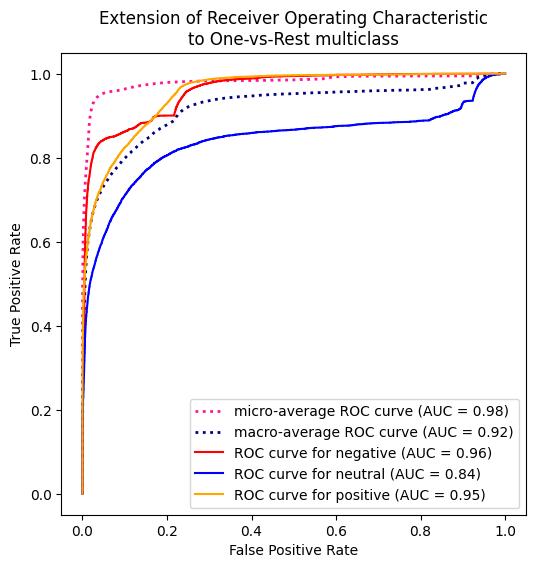

In [ ]:
print(classification_report(y_test, y_test_pred))
print()
print("f1_score:", f1_score(y_test, y_test_pred, average="weighted"))
print("accuracy:", accuracy_score(y_test, y_test_pred))
print("precision:", precision_score(y_test, y_test_pred, average="weighted"))
print("roc_auc:", roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr"))

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

class_of_interest = 1
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_test_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_test_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(3):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= 3

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

fig, ax = plt.subplots(figsize=(6, 6))

target_names = ['negative', 'neutral', 'positive']

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=2,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=2,
)

colors = cycle(["red", "blue", "orange"])
for class_id, color in zip(range(3), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_test_pred_proba[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass",
)